In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from utils.data_utils import DataLoader
import random

/home/hs/anaconda3/envs/tf28/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cfg = {}
cfg['data'] = {}
cfg['data']['name'] = 'voc'
cfg['data']['labels'] = {}
# cfg['data']['labels']['name'] = ['Nam Joo-hyuk', 'Kim Da-mi', 'Kim Seong-cheol', 
#                                  'Yoo Jae-suk', 'Kim Tae-ri', 'Choi Woo-shik']
cfg['data']['labels']['name']=['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 
       'bus', 'car', 'cat', 'chair', 'cow', 
       'diningtable', 'dog', 'horse', 'motorbike', 'person', 
       'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
cfg['batch_size'] = 1
cfg['model'] = {}
cfg['model']['anchors'] = np.zeros((3,3,2))
cfg['data']['labels']['count'] = 6
cfg['model']['input_size'] = np.array([512, 512])
cfg['seed'] = 42
cfg['data']['max_bboxes'] = 100
cfg['aug'] = {'mosaic':0, 'random_scale':1.0, 'random_rotate90':0.75,
              'random_flip_horizontal':0.5, 'random_crop':1.0,
              'random_gaussian_blur':0.3, 'random_brightness':0.5,
              'random_hue':0.5, 'random_satuation':0.5, 'random_contrast':0.5}
cfg['batch_size'] *= cfg['aug']['mosaic']

In [3]:
dataloader = DataLoader(cfg)
train_dataset = dataloader('train', cfg['batch_size'], aug=cfg['aug'])
val_dataset = dataloader('val')

data = []
for e in range(1):
    for i, (batch_images, batch_labels) in enumerate(train_dataset):
        data += [[batch_images,batch_labels]]
        if i==4:
            break

Dataset: voc train
./data/voc/train.tfrecord is exist


2024-03-15 16:27:16.361604: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-15 16:27:16.441616: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-15 16:27:16.441823: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-15 16:27:16.442403: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Dataset: voc val
./data/voc/val.tfrecord is exist


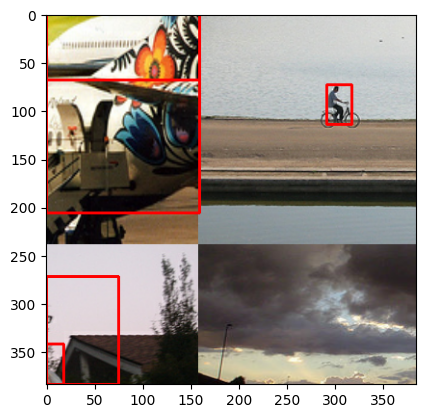

In [4]:
"""
1. crop, resize_padding
2. mosaic 구현
3. rotate90, color_method, gaussian filter size 변경
4. 재현성 확인
"""
b=3
idx = 0
image =(data[b][0][idx].numpy()*255).astype(np.uint8)
labels = data[b][1]
labels = labels[labels[..., 0] == idx].numpy().astype(np.int32)

for i, x1, y1, x2, y2, c in labels:
    cv2.rectangle(image, [x1,y1], [x2,y2], [255, 0, 0], 2)
plt.imshow(image)
plt.show() 

In [5]:
labels

array([[  0,   0,   0, 159, 206,   0],
       [  0,   0,   0, 159,  68,   0],
       [  0, 291,  73, 317, 114,  14],
       [  0,   0, 342,  18, 384,   4],
       [  0,   0, 272,  75, 384,  14]], dtype=int32)

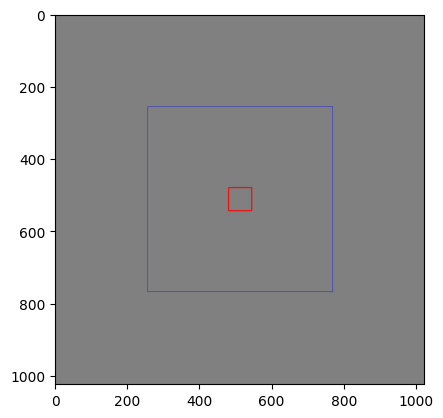

In [5]:
i = (np.zeros([1024,1024,3])+128).astype(np.uint8)
s = 5
x1, y1 = 1024//2**s*(2**(s-1)-1), 1024//2**s*(2**(s-1)-1)
x2, y2 = 1024//2**s*(2**(s-1)+1), 1024//2**s*(2**(s-1)+1)
cv2.rectangle(i, [x1, y1], [x2, y2], [255, 0, 0], 2)
cv2.rectangle(i, [256, 256], [768, 768], [0, 0, 255])
plt.imshow(i)
plt.show()

In [8]:
x1

448

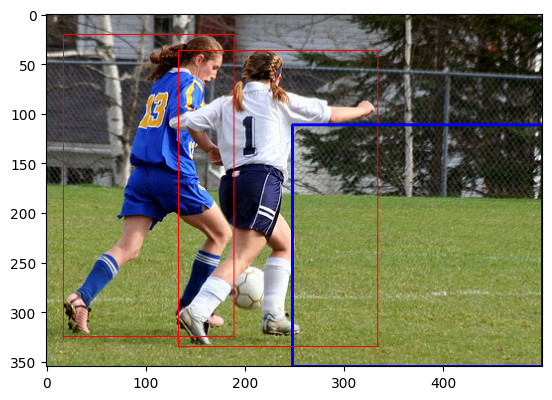

In [11]:
idx = 12
image = (data[idx][0][0].numpy()*255).astype(np.uint8)
labels = data[idx][1].numpy().astype(np.int32)
image_ = image.copy()
for b, x1, y1, x2, y2, c in labels:
    cv2.rectangle(image_, [x1,y1], [x2,y2], [255, 0, 0], 1)
cv2.rectangle(image_, [w1,h1], [w2,h2], [0,0,255], 2)
plt.imshow(image_)
plt.show()

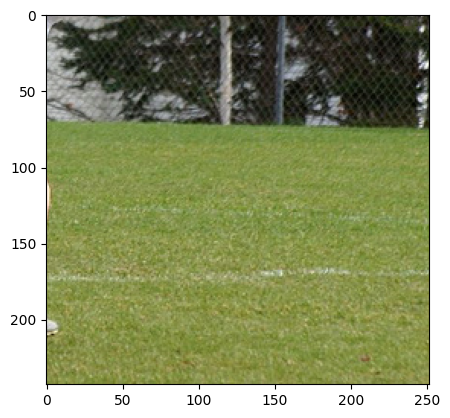

In [10]:
h,w = image.shape[:2]
h1, h2 = h//2-65, h
w1, w2 = w//2-2, w
image2 = image[h1:h2, w1:w2].copy()
plt.imshow(image2)
plt.show()

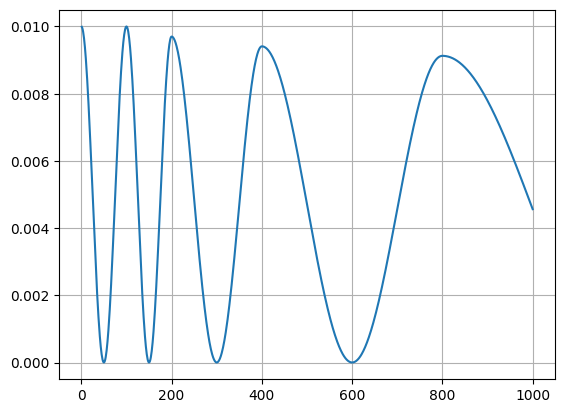

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import yaml
from utils.lr_shcedulers import LR_scheduler

with open('yaml/config.yaml') as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)
cfg['train']['lr_scheduler']['name'] = 'custom'
cfg['train']['lr_scheduler']['warmup_epochs']=0

epochs=1
step_per_epoch = 1000
lr_scheduler = LR_scheduler(cfg['train']['lr_scheduler'], epochs, step_per_epoch)

steps = []
lrs = []
for epoch in range(1, epochs+1):
    for step in range((epoch-1)*step_per_epoch+1, epoch*step_per_epoch+1):
        steps += [step]
        lrs += [lr_scheduler(step)]

plt.plot(steps, lrs)
plt.grid(True)

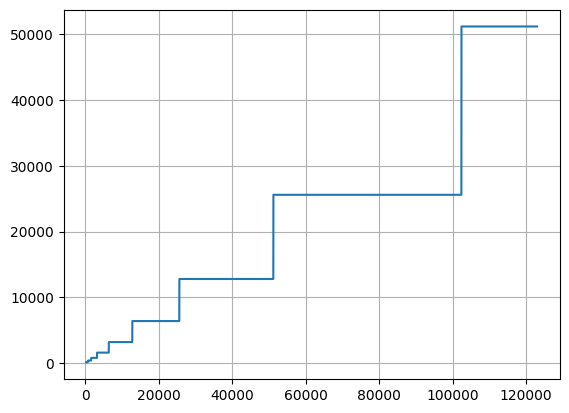

In [2]:
plt.plot(steps, t)
plt.grid(True)

In [15]:
lrs[-1]

4.99999999999945e-06

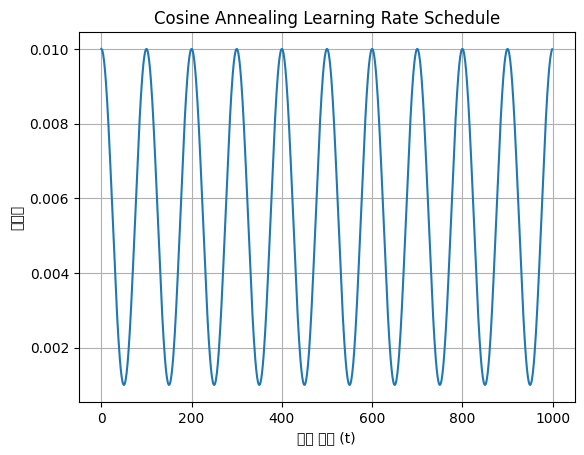

In [21]:
import numpy as np
import matplotlib.pyplot as plt

def cosine_annealing(t, min_lr, max_lr, t_max):
    return min_lr + 0.5 * (max_lr - min_lr) * (1 + np.cos(t / t_max * np.pi))

t_values = np.arange(0, 1000, 1)  # 학습 단계는 0부터 99까지
min_lr = 0.001  # 최소 학습률
max_lr = 0.01   # 최대 학습률
t_max = 50      # 주기

lr_values = cosine_annealing(t_values, min_lr, max_lr, t_max)

plt.plot(t_values, lr_values)
plt.xlabel('학습 단계 (t)')
plt.ylabel('학습률')
plt.title('Cosine Annealing Learning Rate Schedule')
plt.grid(True)
plt.show()


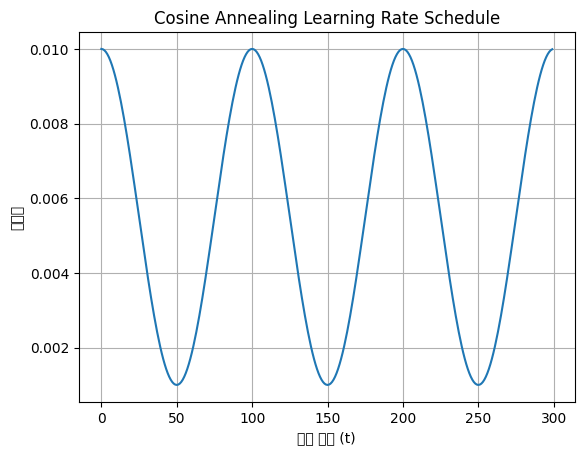

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def cosine_annealing(t, min_lr, max_lr, t_max):
    return min_lr + 0.5 * (max_lr - min_lr) * (1 + np.cos(t / t_max * np.pi))

t_values = np.arange(0, 300, 1)  # 학습 단계는 0부터 99까지
min_lr = 0.001  # 최소 학습률
max_lr = 0.01   # 최대 학습률
t_max = 50      # 초기 주기
t_max_increment = 0.00  # 주기 증가량

lr_values = []
for t in t_values:
    lr_values.append(cosine_annealing(t, min_lr, max_lr, t_max))
    if t % t_max == 0 and t != 0:
        t_max += t_max * t_max_increment  # 주기를 조금씩 증가시킴

plt.plot(t_values, lr_values)
plt.xlabel('학습 단계 (t)')
plt.ylabel('학습률')
plt.title('Cosine Annealing Learning Rate Schedule')
plt.grid(True)
plt.show()


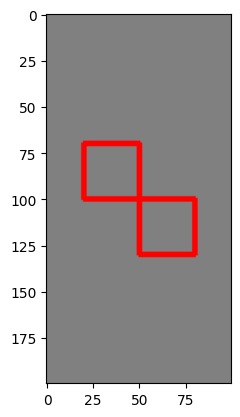

In [1]:
import tensorflow as tf
from utils.aug_utils import resize_padding, resize, resize_padding_without_labels
import numpy as np
import cv2
import matplotlib.pyplot as plt

image = np.zeros((200,100,3), np.float32) + 128
labels = np.array([[20,70,50,100,0],[50,100,80,130,0]], np.float32)
image_ = image.astype(np.uint8)
for x1,y1,x2,y2,c in labels.astype(np.int32):
    cv2.rectangle(image_, [x1,y1], [x2,y2], [255, 0, 0], 2)
plt.imshow(image_)
plt.show()

2024-03-15 10:27:19.748345: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-15 10:27:19.769986: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-15 10:27:19.770203: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-15 10:27:19.770790: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

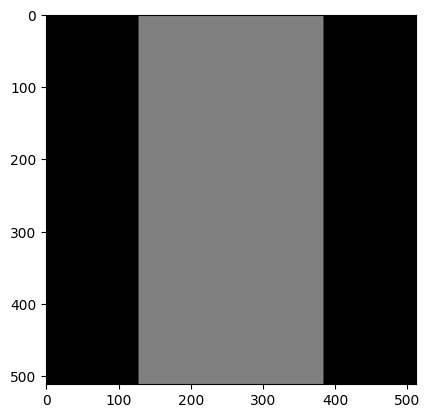

In [2]:
imager, labelsr = resize_padding_without_labels(image, tf.constant([512, 512], tf.float32))
image_ = imager.numpy().astype(np.uint8)
# for x1,y1,x2,y2,c in labelsr.numpy().astype(np.int32):
#     cv2.rectangle(image_, [x1,y1], [x2,y2], [255, 0, 0], 2)
plt.imshow(image_)
plt.show()

In [25]:
def crop(image, labels, xyxy=None, seed=42):
    if xyxy is None:
        size = tf.cast(tf.shape(image)[-2:-4:-1], tf.float32)
        x1, y1 = tf.unstack(tf.cast(tf.random.uniform([2], minval=[0,0], maxval=size//3, seed=seed), tf.int32))
        x2, y2 = tf.unstack(tf.cast(tf.random.uniform([2], minval=size//3*2, maxval=size, seed=seed), tf.int32))
    else:
        x1, y1, x2, y2 = tf.unstack(xyxy)
    
    crop_image = image[y1:y2, x1:x2]
    flag = tf.logical_and(tf.reduce_all(labelsr[..., 2:4] > [x1, y1], -1),
                           tf.reduce_all(labelsr[..., :2] < [x2, y2], -1))
    filtered_labels = labels[flag]
    crop_labels = tf.concat([tf.maximum(filtered_labels[..., :2] - [x1, y1], 0),
                             filtered_labels[..., 2:4] - [x1, y1] - tf.maximum(filtered_labels[..., 2:4] - [x2, y2], 0),
                             filtered_labels[..., 4:]], -1)
    return crop_image, crop_labels

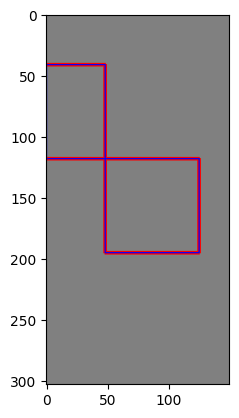

In [37]:
xyxy = np.array([100, 50, 300, 150])
imagec, labelsc = crop(image_, labelsr)
imagecc = imagec.astype(np.uint8)
for x1, y1, x2, y2, c in labelsc.numpy().astype(np.int32):
    cv2.rectangle(imagecc, [x1,y1], [x2,y2], [0, 0, 255], 1)
plt.imshow(imagecc)
plt.show()

In [12]:
imager[y1:y2, x1:x2].shape

TensorShape([77, 77, 3])

tf.Tensor(150, shape=(), dtype=int32) tf.Tensor(40, shape=(), dtype=int32) tf.Tensor(256, shape=(), dtype=int32) tf.Tensor(128, shape=(), dtype=int32)


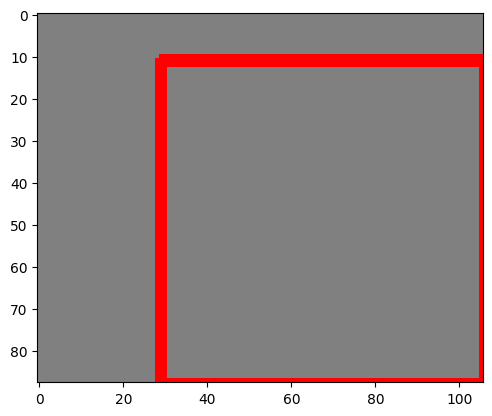

In [37]:

image_ = imagec.astype(np.uint8)
plt.imshow(image_)
plt.show()

In [12]:
import time
import tensorflow as tf
q=tf.constant([1])

In [58]:
f = tf.zeros([3,5], tf.float32)
st=time.time()
d=[]
for idx in range(10):
    b=[]
    for _ in range(3):
        a=f[i]
        b+=[a]
c=tf.concat([b],0)
d += [tf.concat([tf.zeros(c.shape[:-1], dtype=tf.float32)[..., None]+idx, c], -1)]

time.time()-st, tf.concat(d, 0).shape

(0.0067901611328125, TensorShape([3, 6]))

In [59]:
f = tf.zeros([3,5], tf.float32)
st=time.time()
d=[]
for idx in range(10):
    b=[]
    for i in range(3):
        a=f[i]
        b+=[tf.concat([tf.zeros(a.shape[:-1], dtype=tf.float32)[..., None]+idx, a], -1)]
c=tf.concat([b],0)
d += [c]

time.time()-st, tf.concat(d, 0).shape

(0.013540029525756836, TensorShape([3, 6]))